# Task 1 - Time-series prediction with neural networks

### Library imports

In [ ]:
# Math
import math
from random import gauss, random
import statsmodels.api as sm

# Data management
import numpy as np
from pandas import Series

# Neural networks
import torch
import torch.nn as nn
from torch.autograd import Variable
import keras

# ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Plotting
from matplotlib.pyplot import plot, show, xlim, ylim, legend, subplots, title, yscale, ylabel, xlabel
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Metrics
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape, mean_absolute_error as mae
from statsmodels.tsa.stattools import adfuller

## Task 1.1 - Prediction with MLP, RNN, LSTM using synthetic series

### Helper functions

In [ ]:
# Generates series with start, end, step as input arguments
# Returns 80% of the series as training data, remaining 20% as test data
def gen_series(start : float, end : float, step : float):
    i = start
    series = np.array([])
    while (i < end):
        series = np.append(series, i)
        i += step
    
    train_index = math.floor(0.8*len(series))
    train_data = np.array(series[0:train_index])
    test_data = np.array(series[train_index:])

    return train_data, test_data

# Function to convert data into supervised learning data sets
# Returns input data and labels as two numpy arrays
def transform_data_set(data, input_size, output_size):
    arr_len = len(data) - (input_size - 1) - output_size
    input_data = np.zeros((arr_len, input_size))
    label = np.zeros((arr_len, output_size))

    for i in range(arr_len):
        for j in range(input_size):
            input_data[i, j] = data[i + j]
        for k in range(output_size):
            if(i < (arr_len)):
                label[i, k] = data[i + input_size + k]

    return input_data, label


# Adds white noise to existing series
# data should be non-transformed data set, aka output from gen_series()
def add_white_noise(data : np.ndarray, mean: int = 0, var: int = 1):
    # Generate white noise
    wn = np.random.normal(mean, var, len(data))

    # Find mean of generated data
    # Used to control amplitude of white noise
    mean = data.mean()
    wn = wn * mean

    # Add white noise to data
    wn_data = data + wn

    return wn_data

# Generates a time series in the form of a sinusoidal wave
# Returns index, training data (80%), and testing data (20%)
def gen_sin(period_time : int = 20, sample_rate : int = 100, amplitude : int = 1, periods : int = 1):
    # Current interpretation of sample_rate: sample_rate * frequency (inv. periods) equals amount of datapoints needed for a single period
    x = np.linspace(0, period_time * periods, sample_rate * period_time)
    data = np.sin(2 * np.pi * sample_rate * x)
   
    train_index = math.floor(0.8*len(data))
    train_data = np.array(data[0:train_index])
    test_data = np.array(data[train_index:])

    return x, train_data, test_data

### Task 1.1.1
An equal-difference series starting from 0, ending to 1 (excluding 1), with a length
of 200 points (step = 0.005).
Design an MLP for one-step prediction. The output vector has a size of 1. Let the
input vector be a size of 4.

In [ ]:
# Generate equal-difference series, 0 to 1 (excl.), len = 200, step 0.005
train_data, test_data = gen_series(0, 1, 0.005)

# Split training and test data into supervised learning format with input data and labels
train_input_data, train_label = transform_data_set(train_data, 4, 1)
test_input_data, test_label = transform_data_set(test_data, 4, 1)
#### Design MLP
# Define hyperparameters for MLP model with one-step prediction
input_size = 4
hidden_size = 10
output_size = 1
num_epochs = 100
learning_rate = 0.01

# Define model class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)

        return out

# Initialize model
model = MLP(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = Variable(torch.from_numpy(train_input_data).float())
    labels = Variable(torch.from_numpy(train_label).float())

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 5 == 0:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, loss.item()))

# Test model
model.eval()
var_test_input_data = Variable(torch.from_numpy(test_input_data).float())
test_output = model(var_test_input_data)

# Find MSE of test data
test_mse = criterion(test_output, Variable(torch.from_numpy(test_label).float()))
print('Test MSE: %.4f' % (test_mse.item()))

# Plot training data, test data, and predicted test data
plot(train_data, label='Training data')
plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data, label='Test data')
plot(np.arange(len(train_data), len(train_data) + len(test_data) - input_size), test_output.data.numpy(), label='Predicted test data', linestyle='--')
title(f'MLP with simple synthetic series, MSE: {test_mse.item():.6f}')
legend()
show()

### Task 1.1.2
An equal-difference series starting from 0, ending to 1, with a length of 200 points
(step = 0.005), plus white noise i.e., random variable with zero mean and 1 variance.
You may need to control the amplitude of the noise series in order to control the
signal-noise ratio.
Design an MLP for one-step prediction. The output vector has a size of 1. Let the
input vector be a size of 4.

In [ ]:
test_mse = 1
while (test_mse > 0.01):
    # Generate equal-difference series, 0 to 1 (excl.), len = 200, step 0.005
    train_data, test_data = gen_series(0, 1, 0.005)

    wn_train_data = add_white_noise(train_data, mean = 0, var = 0.1)
    wn_test_data = add_white_noise(test_data, mean = 0, var = 0.1)


    # Split training and test data into supervised learning format with input data and labels
    train_input_data, train_label = transform_data_set(wn_train_data, 4, 1)
    test_input_data, test_label = transform_data_set(wn_test_data, 4, 1)
    # Define hyperparameters for MLP model with one-step prediction
    input_size = 4
    hidden_size = 5
    output_size = 1
    num_epochs = 1000
    learning_rate = 0.001

    # Define model class
    class MLP(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_size,output_size)

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)

            return out

    # Initialize model
    model = MLP(input_size, hidden_size, output_size)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



    # Train model
    for epoch in range(num_epochs):
        # Convert numpy arrays to torch tensors
        inputs = Variable(torch.from_numpy(train_input_data).float())
        labels = Variable(torch.from_numpy(train_label).float())

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss
        # if (epoch + 1) % 100 == 0:
        #     print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, loss.item()))

    # Test model
    model.eval()
    var_test_input_data = Variable(torch.from_numpy(test_input_data).float())
    test_output = model(var_test_input_data)

    # Find MSE of test data
    test_mse = criterion(test_output, Variable(torch.from_numpy(test_label).float()))
    print('Test MSE: %.4f' % (test_mse.item()))

# Plot training data, test data, and predicted test data
plot(train_input_data[:,0], label='Training data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_input_data)), test_input_data[:,0], label='Test data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_data) - input_size), test_output.data.numpy(), label='Predicted test data', linestyle='--')
title(f'MLP with white-noised synthetic series, MSE: {test_mse.item():.6f}')
legend()
show()

### Task 1.1.3
A deterministic series sampled from a sinusoidal wave with period 20 seconds, with
a sample rate of 100 Hz. Generate sufficient samples (at least 3 periods of data) as
needed to achieve good performance, e.g. MSE (mean squared error) below 0.5.

Design an RNN and a LSTM for two-step prediction. The output vector has a size
of 2. Set the input vector size by yourself.

#### RNN

In [ ]:
# Generate sine wave
x, train_data, test_data = gen_sin(periods = 3)

# Split training and test data into supervised learning format with input data and labels
train_input_data, train_label = transform_data_set(train_data, 4, 2)
test_input_data, test_label = transform_data_set(test_data, 4, 2)

# Design RNN model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(5, input_shape=(4, 1), return_sequences=False))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_input_data, train_label, epochs=10, batch_size=1, verbose=2)

# Test model
test_output = model.predict(test_input_data)

# Find MSE of test data
test_mse = keras.losses.mean_squared_error(test_label, test_output)
print('Test MSE: %.4f' % (sum(test_mse) / 395))


# Plot training data, test data, and predicted test data
plot(train_input_data[:,0], label='Training data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_input_data)), test_input_data[:,0], label='Test data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_data) - input_size - 1), test_output[:,0], label='Predicted test data', linestyle='--')
title(f'RNN with simple sinusoid, MSE: {(sum(test_mse) / 395):.6f}')
legend()
show()


#### LSTM

In [ ]:
# Design LSTM model with Keras
model = keras.models.Sequential()
model.add(keras.layers.LSTM(5, input_shape=(4, 1), return_sequences=False))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_input_data, train_label, epochs=10, batch_size=1, verbose=2)

# Test model
test_output = model.predict(test_input_data)

# Find MSE of test data
test_mse = keras.losses.mean_squared_error(test_label, test_output)
print('Test MSE: %.4f' % (sum(test_mse) / 395))


# Plot training data, test data, and predicted test data
plot(train_input_data[:,0], label='Training data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_input_data)), test_input_data[:,0], label='Test data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_data) - input_size - 1), test_output[:,0], label='Predicted test data', linestyle='--')
title(f'LSTM with simple sinusoid, MSE: {(sum(test_mse) / 395):.6f}')
legend()
show()


### Task 1.1.4

A stochastic series sampled from a sinusoidal wave with period 20 seconds, with a sample rate of 100 Hz, plus random white noise i.e., random variable with zero mean and 1 variance. Control the amplitude of the noise with a fractional number, e.g. 0.1.

Design an RNN and a LSTM for two-step prediction. The output vector has a size of 2. Set the input vector size by yourself.

#### RNN

In [ ]:
# Generate sine wave
x, train_data, test_data = gen_sin(periods = 3)

# Add white noise to training and test data
train_data_wn = add_white_noise(train_data, 0, 0.5)
test_data_wn = add_white_noise(test_data, 0, 0.1)

# Split training and test data into supervised learning format with input data and labels
train_input_data, train_label = transform_data_set(train_data_wn, 4, 2)
test_input_data, test_label = transform_data_set(test_data_wn, 4, 2)

# Design RNN model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(5, input_shape=(4, 1), return_sequences=False))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_input_data, train_label, epochs=10, batch_size=1, verbose=2)

# Test model
test_output = model.predict(test_input_data)

# Find MSE of test data
test_mse = keras.losses.mean_squared_error(test_label, test_output)
print('Test MSE: %.4f' % (sum(test_mse) / 395))

# Plot training data, test data, and predicted test data
plot(train_input_data[:,0], label='Training data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_input_data)), test_input_data[:,0], label='Test data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_data) - input_size - 1), test_output[:,0], label='Predicted test data', linestyle='--')
title(f'RNN with white-noised sinusoid, MSE: {(sum(test_mse) / 395):.6f}')
legend()
show()


#### LSTM

In [ ]:
# Design LSTM model with Keras
model = keras.models.Sequential()
model.add(keras.layers.LSTM(5, input_shape=(4, 1), return_sequences=False))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_input_data, train_label, epochs=10, batch_size=1, verbose=2)

# Test model
test_output = model.predict(test_input_data)

# Find MSE of test data
test_mse = keras.losses.mean_squared_error(test_label, test_output)
print('Test MSE: %.4f' % (sum(test_mse) / 395))

# Plot training data, test data, and predicted test data
plot(train_input_data[:,0], label='Training data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_input_data)), test_input_data[:,0], label='Test data')
plot(np.arange(len(train_input_data), len(train_input_data) + len(test_data) - input_size - 1), test_output[:,0], label='Predicted test data', linestyle='--')
title(f'LSTM with white-noised sinusoid, MSE: {(sum(test_mse) / 395):.6f}')
legend()
show()


## Task 1.2 - Predict white noise, random walk, an ARMA process using neural networks

Dataset. We use three synthetic data sets, each with 1000 data points.
1. A pure white-noise signal.
2. A random-walk series.
3. A stationary series generated by an ARMA(2, 2) process. Make sure that the process
with right parameters generates a stationary series.

### Helper functions

In [ ]:
# White noise: Variables are independent, identically distributed (iid), mean = 0 
# Returns x and white noise array, use both in plot(x, wn) to ensure right scaling
def gen_wn_series(start : int = 0, end : int = 1, step : int = 100, var : int = 1):
    x = np.linspace(start, end, step)
    wn = [gauss(0.0, var) for _ in range(step)]
    wn = np.array(wn)

    return x, wn

# Random walk: Variables are not iid, mean = 0
# Returns x and random walk array, use both in plot(x, rw) to ensure right scaling
def gen_rw_series(start : int = 0, end : int = 1, step : int = 100, var : int = 1):
    x = np.linspace(start, end, step)
    rw = [0]
    for i in range(1, step):
        rw.append(rw[i-1] + gauss(0.0, var))
    rw = np.array(rw)

    return x, rw

# Generate ARMA(p, q) series using statsmodels
def gen_arma_series(p : int = 1, q : int = 1, start : int = 0, end : int = 1, step : int = 100, var : int = 1):
    x = np.linspace(start, end, step)
    arma = sm.tsa.arma_generate_sample(ar = [1, p], ma = [1, q], nsample = step, scale = var)
    arma = np.array(arma)

    return x, arma

# Ljungbox test used to determine randomness
def ljungbox(series: Series):
    print(sm.stats.acorr_ljungbox(series))

# Function to convert data into supervised learning data sets
# Returns input data and labels as two numpy arrays
def transform_data_set(data, input_size, output_size):
    arr_len = len(data) - (input_size - 1) - output_size
    input_data = np.zeros((arr_len, input_size))
    label = np.zeros((arr_len, output_size))

    for i in range(arr_len):
        for j in range(input_size):
            input_data[i, j] = data[i + j]
        for k in range(output_size):
            if(i < (arr_len)):
                label[i, k] = data[i + input_size + k]

    return input_data, label


In [ ]:
# Generate white noise series
x_wn, wn = gen_wn_series(start = 0, end = 100, step = 1000, var = 0.5)
# Generate random walk series
x_rw, rw = gen_rw_series(start = 0, end = 100, step = 1000)
# Generate ARMA(2, 2) series
x_arma, arma = gen_arma_series(p = 2, q = 2, start = 0, end = 100, step = 1000)

# Transform data sets into supervised-learning data sets
input_data_wn, label_wn = transform_data_set(wn, 4, 2)
input_data_rn, label_rn = transform_data_set(rw, 4, 2)
input_data_arma, label_arma = transform_data_set(arma, 4, 2)


# Tensorize data sets
input_data_wn = input_data_wn.reshape((input_data_wn.shape[0], input_data_wn.shape[1], 1))
label_wn = label_wn.reshape((label_wn.shape[0], label_wn.shape[1], 1))
input_data_rn = input_data_rn.reshape((input_data_rn.shape[0], input_data_rn.shape[1], 1))
label_rn = label_rn.reshape((label_rn.shape[0], label_rn.shape[1], 1))
input_data_arma = input_data_arma.reshape((input_data_arma.shape[0], input_data_arma.shape[1], 1))
label_arma = label_arma.reshape((label_arma.shape[0], label_arma.shape[1], 1))


# Create LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(100, activation='tanh', input_shape=(4, 1)))
model.add(keras.layers.Dense(2))
model.compile(optimizer='adam', loss='mse')



# Predict white noise series
model.fit(input_data_wn, label_wn, epochs=50, batch_size=1, verbose=0)
wn_output = model.predict(input_data_wn)
# Calculate MSE of predicted white noise series
wn_mse = keras.losses.mean_squared_error(label_wn[:,:,0], wn_output)
print('White noise MSE: %.4f' % (sum(wn_mse) / len(wn_mse)))



# Predict random walk series
model.fit(input_data_rn, label_rn, epochs=50, batch_size=1, verbose=0)
rn_output = model.predict(input_data_rn)
# Calculate MSE of predicted random walk series
rn_mse = keras.losses.mean_squared_error(label_rn[:,:,0], rn_output)
print('Random walk MSE: %.4f' % (sum(rn_mse) / len(rn_mse)))



# Predict ARMA(2, 2) series
model.fit(input_data_arma, label_arma, epochs=50, batch_size=1, verbose=0)
arma_output = model.predict(input_data_arma)
# Calculate MSE of predicted ARMA(2, 2) series
arma_mse = keras.losses.mean_squared_error(label_arma[:,:,0], arma_output)
print('ARMA(2, 2) MSE: %.4f' % (sum(arma_mse) / len(arma_mse)))

In [ ]:
# Create subplot for 3 plots
fig, axs = subplots(3, 1, figsize=(10, 10))


# Plot white noise series, predicted white noise series
axs[0].plot(x_wn, wn, label='White noise')
axs[0].plot(x_wn[5:], wn_output[:,0], label='Predicted white noise', linestyle='--')
axs[0].legend()
axs[0].set_title('White noise series and predicted series, MSE %.4f' %  (sum(wn_mse) / len(wn_mse)))
# Plot random walk series, predicted random walk series
axs[1].plot(x_rw, rw, label='Random walk')
axs[1].plot(x_rw[5:], rn_output[:,1], label='Predicted random walk', linestyle='--')
axs[1].legend()
axs[1].set_title('Random walk series and predicted series, MSE %.4f' %  (sum(rn_mse) / len(rn_mse)))
# Plot arma(2, 2) series, predicted arma(2, 2) series
axs[2].plot(x_arma, arma, label='ARMA(2, 2)')
axs[2].plot(x_arma[5:], arma_output[:,1], label='Predicted ARMA(2, 2)', linestyle='--')
axs[2].legend()
axs[2].set_title('ARMA(2, 2) series and predicted series, MSE %.4f' %  (sum(arma_mse) / len(arma_mse)))
show()

## Task 1.3 - Comparison with ARIMA-based modeling and prediction

### Helper functions

In [ ]:
# Function to generate Fibonacci series
def gen_fib_series(start : int = 0, end : int = 50 - 1, step : int = 50):
    x = np.linspace(start, end, step)
    fib = np.zeros(step)
    fib[0] = 0
    fib[1] = 1
    for i in range(2, step):
        fib[i] = fib[i - 1] + fib[i - 2]
    
    fib = Series(fib)
    return x, fib

# Adds white noise to existing series
# data should be non-transformed data set, aka output from gen_fib_series()
def add_white_noise(series : Series, mean: int = 0, var: int = 1):
    # Generate white noise
    wn = np.random.normal(mean, var, len(series))

    # Find mean of generated data
    # Used to control amplitude of white noise
    for i, val in enumerate(series):
        wn[i] = wn[i] * val * 0.25

    # Add white noise to data
    wn_data = series + wn

    return wn_data

# Separate data into training data and testing data
def split_data(data, train_size : float = 0.8):
    train_size = int(len(data) * train_size)
    train, test = data[0:train_size], data[train_size:len(data)]

    test = test.reset_index(drop=True)
    
    return train, test

# Function to convert data into supervised learning data sets
# Returns input data and labels as two numpy arrays
def transform_data_set(data, input_size, output_size):
    arr_len = len(data) - (input_size - 1) - output_size
    input_data = np.zeros((arr_len, input_size))
    label = np.zeros((arr_len, output_size))

    for i in range(arr_len):
        for j in range(input_size):
            input_data[i, j] = data[i + j]
        for k in range(output_size):
            if(i < (arr_len)):
                label[i, k] = data[i + input_size + k]

    return input_data, label

# Test for stationarity
def adfuller_test(data_set: Series):
    result = adfuller(data_set, autolag='AIC')
    adfstat = result[0]
    pvalue = result[1]
    print("-"*30)
    print(f'ADF Statistic: {adfstat}')
    print(f'p-value: {pvalue}')

    critvals_lt_adfstat = 0
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'{key}, {value}')
        if (value < adfstat):
            critvals_lt_adfstat += 1
    print("-"*30)
    print(f"Critical values less than adf statistic: {critvals_lt_adfstat}")
    print(f"p-value is below the 5% significance level: {pvalue < 0.05}")
    print(f"Stationary? {critvals_lt_adfstat == 0 and pvalue < 0.05}")
    print("-"*30)
    print("")

# Difference given data set to ensure stationarity
def difference_data_set(data_set : Series):
    temp_arr = []

    # Difference the data set
    for index, val in enumerate(data_set):
        if (index != 0):
            temp_arr.append(val - prev_val)
        prev_val = val
    
    # Structure data set into Series
    diff_data_set = Series(temp_arr)

    return diff_data_set

### Generate Fibonacci series

In [17]:
x, fib = gen_fib_series()
wn_fib = add_white_noise(fib)
train_input_data, test_input_data = split_data(wn_fib)
train_input_data, train_label = transform_data_set(train_input_data, 4, 2)
test_input_data, test_label = transform_data_set(test_input_data, 4, 2)

train_input_data = np.log(train_input_data[1:])
train_label = np.log(train_label[1:])
test_input_data = np.log(test_input_data[1:])
test_label = np.log(test_label[1:])

### Visualize Data

In [ ]:
# Plot logarithmic Fibonacci series
plot(x, fib, label='Fibonacci series')
plot(x, wn_fib, label='Fibonacci series with white noise')
yscale('log')
legend()
ylabel('Logarithmic scale')
title('Fibonacci series')
show()

### MLP

In [18]:
# Define hyperparameters for MLP model with two-step prediction
input_size = 4
hidden_size = 100
output_size = 2
num_epochs = 100
learning_rate = 0.001

# Define model class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)

        return out

# Initialize model
model = MLP(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Train model
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = Variable(torch.from_numpy(train_input_data).float())
    labels = Variable(torch.from_numpy(train_label).float())

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 1000 == 0:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, loss.item()))

# Test model
model.eval()
var_test_input_data = Variable(torch.from_numpy(test_input_data).float())
test_output = model(var_test_input_data)

# Find MSE, MAE, and MAPE of test data
mlp_mse = mse(test_label, test_output.detach().numpy())
mlp_mae = mae(test_label, test_output.detach().numpy())
mlp_mape = mape(test_label, test_output.detach().numpy())
print('Test MSE: %.4f' % mlp_mse)
print('Test MAE: %.4f' % mlp_mae)
print('Test MAPE: %.4f' % mlp_mape)

# # Plot training data, test data, and predicted test data
# plot(train_data, label='Training data')
# plot(np.arange(len(train_data), len(train_data) + len(test_data)), test_data, label='Test data')
# plot(np.arange(len(train_data), len(train_data) + len(test_data) - input_size), test_output.data.numpy(), label='Predicted test data', linestyle='--')
# legend()
# show()

Test MSE: 1.1361
Test MAE: 0.9516
Test MAPE: 0.0442


### RNN

In [19]:
# Design RNN model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(5, input_shape=(4, 1), return_sequences=False))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_input_data, train_label, epochs=100, batch_size=1, verbose=0)

# Test model
test_output = model.predict(test_input_data)

# Find MSE, MAE, and MAPE of test data
rnn_mse = mse(test_label, test_output)
rnn_mae = mae(test_label, test_output)
rnn_mape = mape(test_label, test_output)
print('Test MSE: %.4f' % rnn_mse)
print('Test MAE: %.4f' % rnn_mae)
print('Test MAPE: %.4f' % rnn_mape)

# # Plot training data, test data, and predicted test data
# plot(train_input_data[:,0], label='Training data')
# plot(np.arange(len(train_input_data), len(train_input_data) + len(test_input_data)), test_input_data[:,0], label='Test data')
# plot(np.arange(len(train_input_data), len(train_input_data) + len(test_data) - input_size - 1), test_output[:,0], label='Predicted test data', linestyle='--')
# legend()
# show()

1/1 [==============================] - 0s 206ms/step
Test MSE: 106.7416
Test MAE: 10.2942
Test MAPE: 0.4763


### LSTM

In [20]:
# Design LSTM model with Keras
model = keras.models.Sequential()
model.add(keras.layers.LSTM(5, input_shape=(4, 1), return_sequences=False))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_input_data, train_label, epochs=100, batch_size=1, verbose=0)

# Test model
test_output = model.predict(test_input_data)

# Find MSE, MAE, and MAPE of test data
lstm_mse = mse(test_label, test_output)
lstm_mae = mae(test_label, test_output)
lstm_mape = mape(test_label, test_output)
print('Test MSE: %.4f' % lstm_mse)
print('Test MAE: %.4f' % lstm_mae)
print('Test MAPE: %.4f' % lstm_mape)

# # Plot training data, test data, and predicted test data
# plot(train_input_data[:,0], label='Training data')
# plot(np.arange(len(train_input_data), len(train_input_data) + len(test_input_data)), test_input_data[:,0], label='Test data')
# plot(np.arange(len(train_input_data), len(train_input_data) + len(test_data) - input_size - 1), test_output[:,0], label='Predicted test data', linestyle='--')
# legend()
# show()

1/1 [==============================] - 1s 501ms/step
Test MSE: 81.9409
Test MAE: 9.0245
Test MAPE: 0.4174


### ARIMA

#### Box-Jenkins

In [10]:
# Test for stationarity
adfuller_test(wn_fib)

# Logarithmize data set
log_fib = np.log(wn_fib[1:])

# Difference data set
diff_log_fib = np.diff(log_fib)

# Test for stationarity
adfuller_test(diff_log_fib)


------------------------------
ADF Statistic: 8.02613525454802
p-value: 1.0
Critial Values:
1%, -3.6155091011809297
5%, -2.941262357486514
10%, -2.6091995013850418
------------------------------
Critical values less than adf statistic: 3
p-value is below the 5% significance level: False
Stationary? False
------------------------------

------------------------------
ADF Statistic: -3.273905104090997
p-value: 0.016085981434082658
Critial Values:
1%, -3.6209175221605827
5%, -2.9435394610388332
10%, -2.6104002410518627
------------------------------
Critical values less than adf statistic: 1
p-value is below the 5% significance level: True
Stationary? False
------------------------------



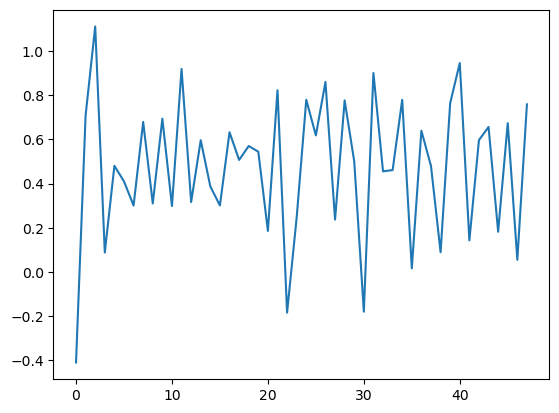

In [11]:
# Plot data set to find seasonality
plot(diff_log_fib)
# No clear occurence of seasonality


/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


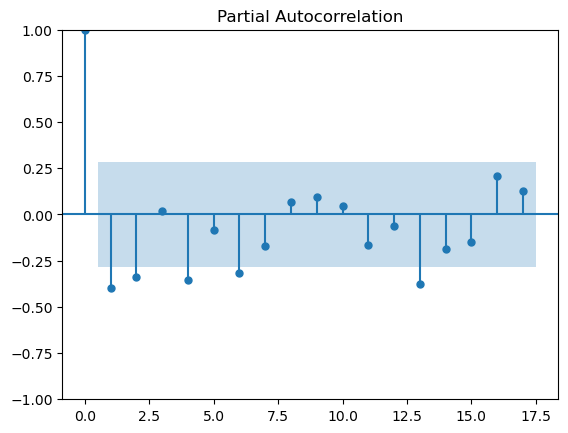

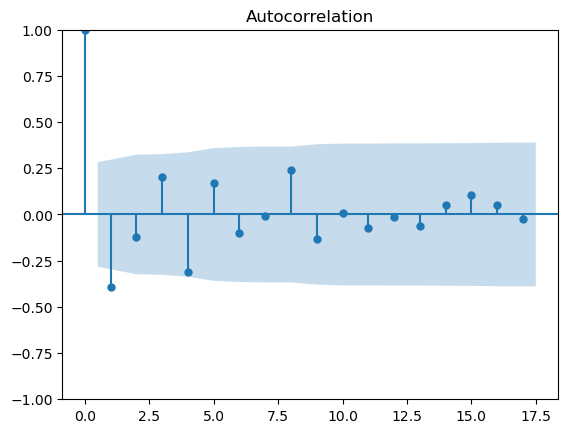

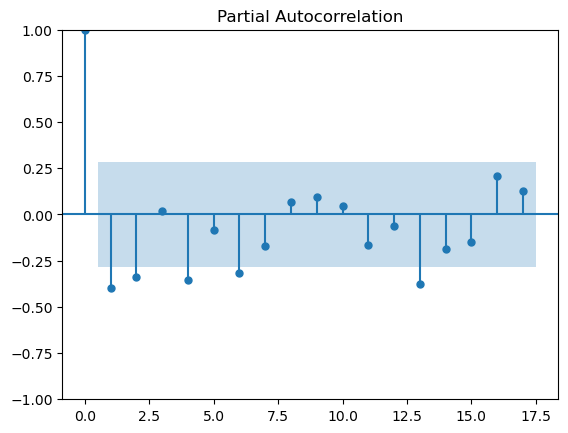

In [12]:
# Order identification
plot_acf(diff_log_fib)
plot_pacf(diff_log_fib)
# p = 3, q = 3

In [13]:
# Model selection
auto_arima(diff_log_fib, start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, trace=True)
# 3, 0, 1 model selected

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=84.381, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=67.094, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=75.688, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=56.793, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=39.570, Time=0.04 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=41.127, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=19.824, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=18.067, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=23.197, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec

Best model:  A

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

#### Model

In [14]:
# Model training
model = ARIMA(diff_log_fib[4:], order=(4, 0, 2)).fit()
model_prediction = model.predict(typ='levels')
# Find MSE, MAE, and MAPE of test data
arima_mse = mse(diff_log_fib[4:], model_prediction)
arima_mae = mae(diff_log_fib[4:], model_prediction)
arima_mape = mape(diff_log_fib[4:], model_prediction)
print('Test MSE: %.4f' % arima_mse)
print('Test MAE: %.4f' % arima_mae)
print('Test MAPE: %.4f' % arima_mape)

/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test MSE: 0.0418
Test MAE: 0.1595
Test MAPE: 0.7449


/home/zanilicious/anaconda3/envs/IL2233/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Comparisons